In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

import time
import os, glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from src.loss import *
from src.model import *
from src.dataset import *

In [2]:
kitti_ds = KittiStereoLidar(
    im_left_dir=glob.glob("data/left_imgs/*/*"), 
    im_right_dir=glob.glob("data/right_imgs/*/*"),
    gt_left_dir=glob.glob("data/left_gt/*/*"), 
    gt_right_dir=glob.glob("data/right_gt/*/*"),
    transform=transforms.Compose([transforms.Resize((192,640)),
                                  transforms.ToTensor()])
)

In [3]:
train_frac=0.6
valid_frac=0.2
indices = list(range(len(kitti_ds)))
np.random.shuffle(indices)

train_split = int(np.floor(train_frac * len(indices)))
valid_split = int(np.floor((train_frac+valid_frac) * len(indices)))
train_indices, valid_indices, test_indices = indices[:train_split], indices[train_split:valid_split], indices[valid_split:]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)
test_sampler = SubsetRandomSampler(test_indices)
#train_indices[:10], valid_indices[:10], test_indices[:10]

In [4]:
batch_size = 4
train_loader = DataLoader(dataset=kitti_ds, 
                          batch_size=batch_size, 
                          sampler=train_sampler,
                          shuffle=False, 
                          num_workers=6)

valid_loader = DataLoader(dataset=kitti_ds, 
                          batch_size=batch_size, 
                          sampler=valid_sampler,
                          shuffle=False, 
                          num_workers=6)

test_loader = DataLoader(dataset=kitti_ds, 
                         batch_size=batch_size, 
                         sampler=test_sampler,
                         shuffle=False, 
                         num_workers=6)

len(train_loader),len(valid_loader),len(test_loader)

(3296, 1099, 1099)

In [5]:
L=torch.load('models/left.pth')
R=torch.load('models/right.pth')

In [6]:
dataiter = iter(train_loader)

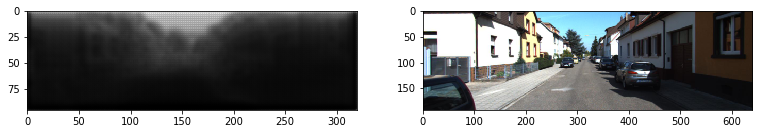

In [9]:
images_l, images_r, scans_l, scans_r = dataiter.next()
depths_l = L(images_l)
npd = np.transpose(depths_l[0].cpu().detach().numpy(), (1,2,0)).squeeze()
npi = np.transpose(images_l[0].cpu().detach().numpy(), (1,2,0))
f, (ax1, ax2) = plt.subplots(1,2, figsize=(13,3))
ax1.imshow(npd, cmap='gray')
ax2.imshow(npi)
plt.show()

In [4]:
# Depth prediction networks for left & right view sets respectively
L = Network()
L = torch.nn.DataParallel(L).cuda()
R = Network()
R = torch.nn.DataParallel(R).cuda()

In [ ]:
#Precalculate mapping parameters
sc = 320/1242
reconstruct_functions = [Reconstruction(date='2011_09_26',scaling=sc), 
                         Reconstruction(date='2011_09_28',scaling=sc),
                         Reconstruction(date='2011_09_29',scaling=sc), 
                         Reconstruction(date='2011_09_30',scaling=sc),
                         Reconstruction(date='2011_10_03',scaling=sc)]

consistency_functions = [Consistency(date='2011_09_26',scaling=sc), 
                         Consistency(date='2011_09_28',scaling=sc),
                         Consistency(date='2011_09_29',scaling=sc), 
                         Consistency(date='2011_09_30',scaling=sc),
                         Consistency(date='2011_10_03',scaling=sc)]

def normalize_prediction(map_input, scale=100):
    M, m=np.amax(map_input), np.amin(map_input)
    return (map_input - m)*(scale / (M-m))

def get_recon_loss(depth_maps, src_imgs, tar_imgs, direction, dates):
    
    batch_loss = 0
    for[dep, src, tar, dat] in zip(depth_maps, src_imgs, tar_imgs, dates):
        if dat=='2011_09_26':
            recf = reconstruct_functions[0]
        elif dat=='2011_09_28':
            recf = reconstruct_functions[1]
        elif dat=='2011_09_29':
            recf = reconstruct_functions[2]
        elif dat=='2011_09_30':
            recf = reconstruct_functions[3]
        elif dat=='2011_10_03':
            recf = reconstruct_functions[4]

        # Calculate sample loss
        sample_loss, _ = recf.compute_loss(dep, src, tar, direction, weighting=True)
        batch_loss += sample_loss

    return batch_loss / batch_size

def get_con_loss(depth_maps, tar_imgs, direction, dates):
    
    batch_loss = 0
    for[dep, tar, dat] in zip(depth_maps, tar_imgs, dates):
        if dat=='2011_09_26':
            recf = consistency_functions[0]
        elif dat=='2011_09_28':
            recf = consistency_functions[1]
        elif dat=='2011_09_29':
            recf = consistency_functions[2]
        elif dat=='2011_09_30':
            recf = consistency_functions[3]
        elif dat=='2011_10_03':
            recf = consistency_functions[4]

        # Calculate sample loss
        sample_loss, _ = recf.compute_loss(dep, tar, direction, weighting=False)
        batch_loss += sample_loss

    return batch_loss / batch_size

def get_su_loss(depth_maps, scan_files):
    
    batch_loss = 0
    for[dep, scan_file] in zip(depth_maps, scan_files):
        dots = np.load(scan_file) 

        sample_loss = gt_loss(dep, dots)
        batch_loss += sample_loss

    return batch_loss / batch_size

In [ ]:
n_epochs = 1
alpha = 1
beta = 0.01
gamma = 0.01

lr = 1e-3
L_optimizer = torch.optim.Adam(L.parameters(), lr=lr)
R_optimizer = torch.optim.Adam(R.parameters(), lr=lr)
#uniform
#exp-1 & beta=0.05 breaks around 2%

In [ ]:
L.train()
R.train()
img=None
for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    s_step, r_step, c_step = 0.0, 0.0, 0.0

    batch_count = 1
    print_every = 5 #20
    time_start = time.time()

    for images_l, images_r, scans_l, scans_r in train_loader:
        L_optimizer.zero_grad()
        R_optimizer.zero_grad()
        
        # Move to cuda
        images_l = images_l.cuda()
        images_r = images_r.cuda()
        
        # Forward pass, make predictions
        depths_l = L(images_l)
        depths_r = R(images_r)

        drive_dates = [s[13:23] for s in scans_l]
        
        # Compute supervised (lidar) losses
        s_loss_L = get_su_loss(depth_maps=depths_l, scan_files=scans_l)
        s_loss_R = get_su_loss(depth_maps=depths_r, scan_files=scans_r)
        
        # Compute reconstruction losses
        r_loss_L = get_recon_loss(depth_maps=depths_l, 
                                  src_imgs=images_l, 
                                  tar_imgs=images_r, 
                                  direction='L2R', dates=drive_dates)
        r_loss_R = get_recon_loss(depth_maps=depths_r, 
                                  src_imgs=images_l, 
                                  tar_imgs=images_l, 
                                  direction='R2L', dates=drive_dates)
        
        # Compute depth map L-R consistency losses
        c_loss_L = get_con_loss(depth_maps=depths_l,  
                                tar_imgs=depths_r, 
                                direction='L2R', dates=drive_dates)
        c_loss_R = get_con_loss(depth_maps=depths_r,  
                                tar_imgs=depths_l, 
                                direction='R2L', dates=drive_dates)
        
        # Weight & sum losses
        loss = (alpha*(s_loss_L + s_loss_R) \
              + beta *(r_loss_L + r_loss_R) \
              + gamma*(c_loss_L + c_loss_R)) / (2*(alpha+beta+gamma))

        # Back propagation & optimize
        loss.backward()
        L_optimizer.step()
        R_optimizer.step()

        train_loss += loss.item()
        s_step += (s_loss_L.item() + s_loss_R.item())
        r_step += (r_loss_L.item() + r_loss_R.item())
        c_step += (c_loss_L.item() + c_loss_R.item())
        
        step_loss = train_loss / (batch_count * batch_size)
        if batch_count % print_every == 0:
            print('Epoch: {} ({:.2f}%)\tStep Loss: {:.6f} \n\tSu: {:.6f} \tUnsu: {:.6f} \tCon: {:.6f} \n\tmax/min:{}'.format(
                epoch+1,
                100*(batch_count / len(train_loader)), 
                step_loss,
                s_step / (batch_count * batch_size),
                r_step / (batch_count * batch_size),
                c_step / (batch_count * batch_size),
                (depths_l[0].max(), depths_l[0].min())
            ))
            npd = np.transpose(depths_l[0].cpu().detach().numpy(), (1,2,0)).squeeze()
            npd = npd[5:-5, 10:-10]
            npd = (npd-np.amin(npd)) / (np.amax(npd) - np.amin(npd) + 1e-4) #normalize display, prevent div by 0
            npi = np.transpose(images_l[0].cpu().detach().numpy(), (1,2,0))
            npi = npi[10:-10, 20:-20]
            
            f, (ax1, ax2) = plt.subplots(1,2, figsize=(13,3))
            ax1.imshow(npd, cmap='gray')
            ax2.imshow(npi)
            plt.show()
        batch_count += 1

    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler) #image pair count
    time_elapsed = time.time() - time_start

    print('Epoch: {} \tTraining Loss: {:.6f} \tTime: {} s'.format(
        epoch+1, 
        train_loss,
        round(time_elapsed, 4)
        ))
